In [1]:
# Heat budget for the different
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [2]:
# Find the uppler and lower layer depth above the sill crest
def Layer(u):
    # Layer interface, zero velocity crossing point
    h1 = np.empty(len(Xp1))
    z_th = np.empty(len(Xp1))
    itf = np.empty(len(Xp1))
    h1[[0,1,-2,-1]] = np.nan
    z_th[[0,1,-2,-1]] = np.nan
    itf[[0,1,-2,-1]] = np.nan
    for i in range(2,len(Xp1)-2):
        l = np.where(u[:, i] < 0)[-1][0]
        itf[i] = l
        z_th[i] = -w[l, i] * (pt[l, i]-T0)
        # Calculate layer depth
        h1[i] = depth[l]
    return (itf, z_th, h1)

state0 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/state700/Hs_012.nc')
t0 = 60 # Start from day 30
tn = len(state0.T) # End day
state = state0.isel(Y = range(1,10), T = range(t0,tn)) # Remove the boundary walls in y direction
X = state.X.data
Xp1 = state.Xp1.data
depth = state.Zl.data
pt = state.Temp.data.mean(axis=(0,2))
u = state.U.data.mean(axis=(0,2))
w = state.W.data.mean(axis=(0,2))
itf, z_th, h1 = Layer(u)

z_th[1:29], z_th[28]

In [6]:
Cp = 4220  # Specific heat content J/kg/C
rho = 1025 # Density
T0 = 9 # Initial temperature
ny = 9 # Number of grids in Y direction
# Grid areas
Area = np.empty(50)
Area[:10] = 100
Area[10:20] = 200
Area[20:30] = 300
Area[30:40] = 800
Area[40:] = 1600


# Xp = 28, 29 for sill top, Xp = 2 for the ice front

files = sorted(glob.glob('/Users/weiyangbao/Documents/Model_outputs/state700/Hs*.nc'))
Hs = np.array([10, 12, 15])

H_f = np.empty(len(Hs)) # Heat flux through the ice front
H_f2 = np.empty(len(Hs)) # 2: lower layer
H_s = np.empty(len(Hs)) # Heat flux through the sill
H_s2 = np.empty(len(Hs))
H_z = np.empty(len(Hs)) # Vertical heat flux
for i in range(len(Hs)):
    state0 = xr.open_dataset(files[i])
    t0 = 60 # Start from day 30
    tn = len(state0.T) # End day
    state = state0.isel(Y = range(1,10), T = range(t0,tn)) # Remove the boundary walls in y direction
    Xp1 = state.Xp1.data
    depth = state.Zl.data
    pt = state.Temp.data.mean(axis=(0,2)) # Z, X
    w = state.W.data.mean(axis=(0,2)) # Zl, X
    u = state.U.data.mean(axis=(0,2)) # Z, Xl
    itf, z_th, h1 = Layer(u)
    
    H_z[i] = z_th[2:29].sum() * 40000 * ny
    Qf = u[:,2] * (pt[:,1]-T0) * Area * ny
    H_f[i] = Qf.sum()
    #H_f2[i] = Qf[np.int(itf[2]):].sum()
    H_f2[i] = Qf[Qf>0].sum()
    Qs = -u[:,28] * (pt[:,27]-T0) * Area * ny
    H_s[i] = Qs.sum()
    H_s2[i] = Qs[np.int(itf[28]):].sum()

In [7]:
H_f,H_f2, H_s, H_s2, H_z

(array([-5640.10238526, -5705.56199388, -5760.53494178]),
 array([5250.07169312, 3517.53382883, 1825.91838352]),
 array([3990.65955207, 4385.86811721, 5234.75426584]),
 array([-3241.0600841 , -3125.52926838, -2592.90339053]),
 array([-4075.33471236, -2449.65185973,  -578.75273409]))

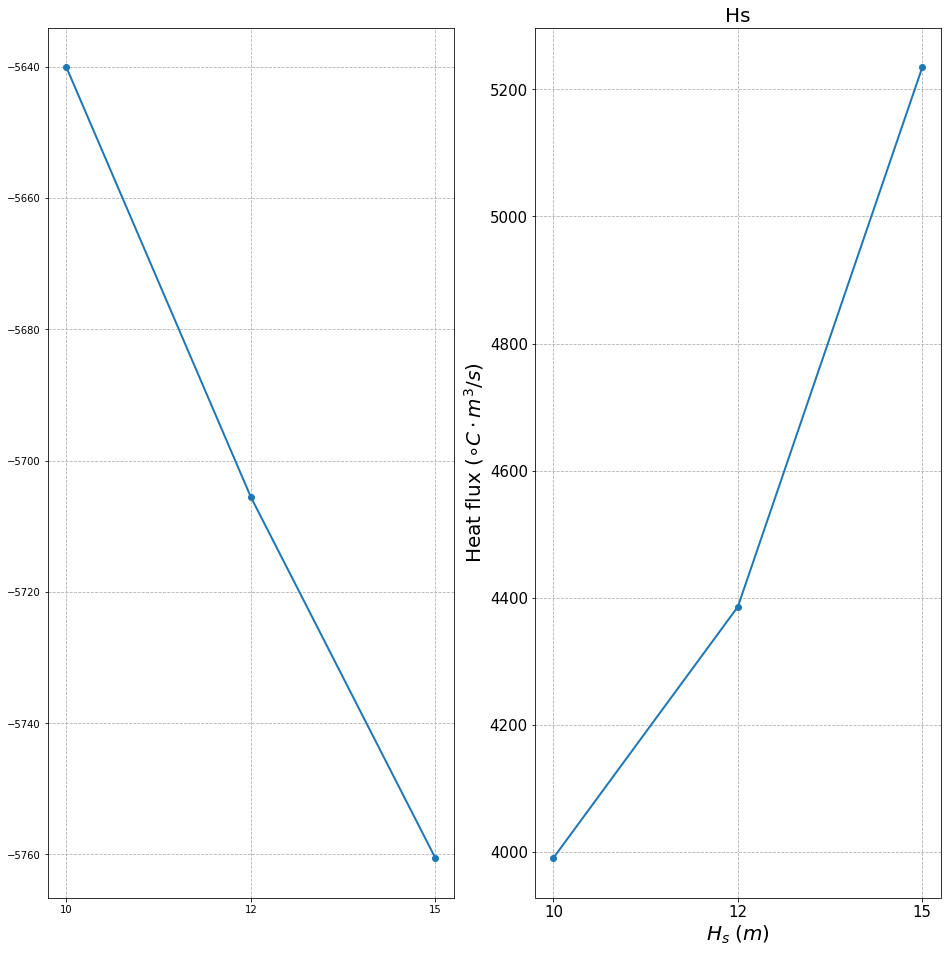

In [5]:
#fig, ax =plt.subplots(figsize=(10,6))
fig, (ax1, ax2) = plt.subplots(1,2,sharex=True, figsize=(16,16))
labels = [10, 12, 15]
#ax1.set_xticklabels(labels)
ax1.grid(linestyle='--')
plt.yticks(fontsize = 15)
plt.xticks(np.arange(3), labels, fontsize=15)
plt.xlabel('$H_s\;(m)$', size=20)
plt.ylabel('Heat flux ($\circ C\cdot m^3/s$)', size=20)
plt.title('Hf', size=20)
ax1.plot(np.arange(3), H_f, 'o-', lw=2)

ax2.grid(linestyle='--')
plt.yticks(fontsize = 15)
plt.xticks(np.arange(3), labels, fontsize=15)
plt.xlabel('$H_s\;(m)$', size=20)
#ax2.ylabel('Heat flux ($\circ C\cdot m^3/s$)', size=20)
plt.title('Hs', size=20)
ax2.plot(np.arange(3), H_s, 'o-', lw=2)